# **COLLEGAMENTO AL DRIVE**

In [35]:
from google.colab import drive
drive.mount('/content/drive')                                                   # Indirizzo base del drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **LIBRERIE**

In [36]:
!reset                                                # Forza il restart

In [75]:
import numpy as np                                    # Importa Numpy
import skimage.io as io                               # Importa il modulo Input/ouput di SK-Image
from skimage.transform import resize                  # Importa il modulo resize da SK-Image
from os import listdir                                # Importa il modulo listdir da OS

import json                                           # Importa Json
from matplotlib.collections import PatchCollection    # Importa PatchCollection dal modulo collections di MatPlotLib
from pycocotools.coco import COCO                     # Importa COCO dal modulo coco di PyCoco-Tools
import pycocotools.mask as cocomask                   # Importa il modulo Mask di PyCoco-Tools
import matplotlib.pyplot as plt                       # Importa il modulo  pyplot di MatPlotLib

from PIL import Image                                 # Importa il modulo Image da PIL

from tensorflow import keras                          # Importa il modulo Keras di TensorFlow
import os                                             # Importa os

Alcuni valori vengono calcolati più e più volte, per riutilizzare i valori calcolati secondo necessità ottimizzando l'esecuzione, implementiamo il modulo lru_cache di functools. Essa consente alla funzione di memorizzare valori già calcolati e di riutilizzarli quando necessario.

In [38]:
from functools import lru_cache                       # Importa il modulo lru_cache da functools

La libreria Segmentation Models utilizza il framework Keras e fornisce diverse funzionalità molto utili per la segmentazione.

In [39]:
!pip install git+https://github.com/qubvel/segmentation_models
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm                      # Importa Segmentation Models usando il framework Keras
from segmentation_models.metrics import iou_score     # Importa iou_score dal modulo Metrics di Segmentation Models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-t0azlvtd
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-t0azlvtd
  Running command git submodule update --init --recursive -q


Configuriamo la memoria della GPU in modo che non sia preallocata e sarà in grado di crescere quando ne avrà bisogno. Ciò comporterà un minore utilizzo della memoria dato che le opzioni predefinite prevedono l'utilizzo della totalità della memoria.

In [40]:
import tensorflow as tf                               # Importa TensorFlow
config = tf.compat.v1.ConfigProto()                   # Crea una configurazione per la sessione che sta per essere eseguita 
config.gpu_options.allow_growth = True                # Configura la sessione per allocare memoria solo se necessario.
sess = tf.compat.v1.Session(config=config)            # Imposta la sessione con la configurazione scelta

# **PATH LETTURA DEL JSON PER LA SEGMENTAZIONE**


Lettura del json con caricamento di tutte le informazioni richieste per la segmentazione


In [41]:
dataset_path = '/content/drive/MyDrive/Garbage_Detection/GARBAGE_DETECTION/data'        # Path dataset
batch_path = '/content/drive/MyDrive/Garbage_Detection/DataSet/batch_'                  # Indirizzo dei batch
anns_file_path = dataset_path + '/' + 'annotations.json'                                # Path json
split_batch_path = '/content/drive/MyDrive/Garbage_Detection/Split/batch_'              # Path per salvataggio dello splittaggio
data_path = '/content/drive/MyDrive/Garbage_Detection/Data_Split'                       # Path base per il training-testing

path_stretched = '/content/drive/MyDrive/Garbage_Detection/Stretch/npa_stretched.npy'               # Path immagini stretchate
path_segm_stretched = '/content/drive/MyDrive/Garbage_Detection/Stretch/npa_segm_stretched.npy'     # Path immagini segmentate stretchate
x_final_batch = '/content/drive/MyDrive/Garbage_Detection/Data_Split/final_x_test.npy'              # Path batch di immagini per test finale
y_final_batch = '/content/drive/MyDrive/Garbage_Detection/Data_Split/final_y_test.npy'              # Path batch di immagini segmentate per test finale
weights_path = '/content/drive/MyDrive/Garbage_Detection/pesi_ST/'                                  # Path dei pesi
data_graph = '/content/drive/MyDrive/Garbage_Detection/Collected_Data_xPresentation/'               # Path grafici

Le informazioni sulle immagini sono completamente raccolte nel .json del nostro DataSet in formato COCO.

In [42]:
# Legge il .json
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

# Prendo le informazioni sulle immagini del .json
imgs = dataset['images']

# Carichiamo il dataset come un coco object
coco = COCO(anns_file_path)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


# **DEFINIZIONE DELLE FUNZIONI DI STRETCH E LETTURA E SCRITTURA SU FILE**

Stretchiamo le immagini per ottenere immagini quadrate della stessa grandezza per poterci lavorare in maniera più intuitiva

In [43]:
@lru_cache(maxsize=None)          # Dimensione della cache (default:128, con None non diamo un limite ma consumiamo molte risorse --> Colab)
def f_stretched(initial_batch, final_batch, batch_path, dimension, f_type):
  ''' 
    Stretcha un'immagine a dimensione quadrata e la carica in un ndarray (utilizza lru_cache)
      # PRECONDIZIONE: immagini divise in batch
      # POSTCONDIZIONE: restituisce un array di immagini stretchate secondo una dimensione quadrata scelta dall'utente

    ----------
    PARAMETRI:
      initial_batch: batch da cui partire
          int
      final_batch: batch finale
          int
      batch_path: indirizzo dei batch del dataset
          string ('/content/drive/MyDrive/Project/DataSet/batch_')
      dimension: dimensione dell'immagine quadrata in uscita
          int
      f_type: scelta se la funzione deve essere utilizzata per immagini (0) o per immagini segmentate (1)
          int

    ----------
    RETURN:
      numpy.ndarray
          4D-array (number_img x dimension x dimension X channel)
  ''' 
  list_img_stretched = list()     # Crea una lista vuota per le immagini stretchate

  for i in range(initial_batch, final_batch):
    num = str(i+1)                 # Casting
    if f_type == 1:
      # listdir: restituisce un elenco contenente i nomi delle voci nella directory data dal path.
      for fname in sorted(listdir(batch_path + num + '/segmentation')):                               

        img = np.float32(io.imread(batch_path + num + '/segmentation/' + fname))/255           # Legge e normalizza le immagini segmentate

        img_stretched = resize(img, (dimension, dimension), order=0)                              # Stretcha le immagini in formato 512x512 con interpolazione Nearest-Neighbour
        img_stretchedbn = to_one_dimension(img_stretched)                                         # Porta l'immagine stretchata da 3 canali a 1 canale
        img_stretchedbn = np.expand_dims(img_stretchedbn, axis=-1)                          # Aggiunge la quarta dimensione
        
        list_img_stretched.append(img_stretchedbn)                                    # Aggiunge un elemento alla fine dell'elenco

    elif f_type == 0:
      # listdir: restituisce un elenco contenente i nomi delle voci nella directory data dal path.
      for fname in sorted(listdir(batch_path + num)):                               
        if fname != 'segmentation': 
          img = np.float32(io.imread(batch_path + num + '/' + fname))/255           # Legge e normalizza le immagini
          img_stretched = resize(img, (dimension, dimension), order=0)                # Stretcha le immagini in formato 512x512 con interpolazione Nearest-Neighbour

          list_img_stretched.append(img_stretched)                                    # Aggiunge un elemento alla fine dell'elenco

    else:
      print("ERRORE F_TYPE ERRATO")
      break

    npa_stretched = np.array(list_img_stretched)                                  # Crea un array di tutte le immagini stretchate

  return npa_stretched

In [44]:
def to_one_dimension(img):
  ''' 
      Estrae il bitplane meno significativo (dove c'è l'informazione della mask binaria della segmentazione) del canale R 
      (è indifferente quale tra RGB tanto ogni bitplane 0 contiene la stessa informazione)
      per alte informazioni vedi: bitplane_test.ipynb
        # PRECONDIZIONE: array 3D (meglio se ancora non stretchato)

      ----------
      PARAMETRI:
        img: array di una immagine RGB
            array [N x N x 3]

    ----------
    RETURN: array di una immagine binaria
            array [N x N x 1]
  ''' 
  
  return (img[ : , : , 0])%2

Utilizziamo il salvataggio su file .npy degli array per comodità e velocità d'uso

In [45]:
def array_on_file(filename, array):
  ''' 
      Salva un array su un file binario
        # PRECONDIZIONE: array caricato
        # POSTCONDIZIONE: restituisce un file caricato con gli elementi dell'array

      ----------
      PARAMETRI:
        filename: nome del file
            string ("filename.ext")
        array:
            numpy.ndarray
  ''' 
  with open(filename, 'wb') as f:             # wb = write binary                                   
    np.save(f, array)
  f.close()

In [46]:
def array_from_file(filename):
  ''' 
      Legge un array da un file binario
        # PRECONDIZIONE: array salvato in un file binario
        # POSTCONDIZIONE: restituisce un array

      ----------
      PARAMETRI:
        filename: nome del file
            string ("filename.ext")

    ----------
    RETURN:
      numpy.ndarray
  ''' 
  with open(filename, 'rb') as f:             # rb = read binary  
    array = np.load(f)
  return array 

# **DEFINIZIONE DELLE FUNZIONI PER LA SEGMENTAZIONE**

In [47]:
# Dimensione della cache (default:128, con None non diamo un limite ma consumiamo molte risorse --> Colab)
@lru_cache(maxsize=None)
def get_id_from_filename(filename):
  ''' 
  Ottiene l'id e la dimensione dell'oggetto images nel file .json attraverso una ricerca avente come chiave il nome (utilizza lru_cache)
    # PRECONDIZIONE: immagini originali divise in cartelle chiamate "batch_<numero [0-15]> e istanza degli oggetti immagine di COCO in memoria
    # POSTCONDIZIONE: restituisce l'id e la dimensione dell'immagine
  ----------
  PARAMETRI:
    filename: <batch>/<nome_file_jpg>: 'batch_13/000022.jpg'
       string

  ----------
  RETURN: 
    img_id: id dell'oggetto immagine con cui trovare l'id dell'oggetto annotations
      int
    dim_img : tupla contenente larghezza e altezza dell'immagine (width, height)
      tuple
  ''' 
  img_id = -1

  for img in imgs:
      if img['file_name'] == filename:
          img_id = img['id']

          dim_img = (img['width'], img['height'])     # Memorizzo la tupla delle dimensioni

          return img_id, dim_img

  # In caso di immagine non trovata:
  if img_id == -1:
      print('Incorrect file name')

In [48]:
# Dimensione della cache (default:128, con None non diamo un limite ma consumiamo molte risorse --> Colab)
@lru_cache(maxsize=None)
def get_rle_form_image_id(img_id):
  ''' 
  Ottiene l'RLE dell'oggetto annotations nel file .json attraverso una ricerca avente chiave l'id dell'oggetto images (utilizza lru_cache)
    # PRECONDIZIONE: immagini originali divise in cartelle chiamate "batch_<numero da 0 a 15>
    # POSTCONDIZIONE: restituisce la lista delle annotations dell'oggetto trovato 
  ----------
  PARAMETRI:
    img_id: id dell'oggetto immagine con cui trovare l'id dell'oggetto annotations
      id

  ----------
  RETURN: 
    anns_sel: il parametro annotations dell'oggetto trovato
      list
  ''' 

  # Carichiamo il dataset come oggetto coco
  coco = COCO(anns_file_path)

  # Carica gli id delle maschere
  annIds = coco.getAnnIds(imgIds=img_id, catIds=[], iscrowd=None)   # Prendi le annotations dell'immagine con id specificato
  anns_sel = coco.loadAnns(annIds)                                  # Carica le annotations dell'id specifico (può memorizzare più rifiuti)
  return anns_sel

In [49]:
# Dimensione della cache (default:128, con None non diamo un limite ma consumiamo molte risorse --> Colab)
@lru_cache(maxsize=None)
def to_mask(polys, size):
    """
    Converte una lista di poligoni in una maschera full size binaria (utilizza lru_cache)
      # PRECONDIZIONE: poligono immagine segmentata con grandezza
      # POSTCONDIZIONE: ritorna una maschera binaria full size di grandezza data da height e width
  ----------
  PARAMETRI:
    polys : list di numpy.ndarray di dimensioni
        list
    size : tupla contenente larghezza e altezza dell'immagine (width, height)
        tuple

  ----------
  RETURN: 
    numpy.ndarray
        maschera full size binaria 2D
    """

    with open ('ann', 'rb') as temp:
      polys = pickle.load(temp)

    width = size[0]
    height = size[1]
    rles = cocomask.frPyObjects(polys, height, width)
    rle = cocomask.merge(rles)
    return cocomask.decode(rle) 

In [50]:
# Dimensione della cache (default:128, con None non diamo un limite ma consumiamo molte risorse --> Colab)
@lru_cache(maxsize=None)
def save_binary_img( curr_path , filename , dim_img ):
  ''' 
  Genera un'immagine binaria della segmentazione e la salva in formato .png con lo stesso nome dell'originale, nella cartella dedicata alle segmentazioni (utilizza lru_cache)
    # PRECONDIZIONE: immagini originali divise in cartelle chiamate "batch_<numero da 0 a 15>
    # POSTCONDIZIONE: singola immagine salvata nella specifica cartella delle annotazioni dello specifico batch
  ----------
  PARAMETRI:
    filename: <batch>/<nome_file_jpg>: 'batch_13/000022.jpg'
       string

  ----------
  RETURN: 
    curr_path: è il path in cui salvare questa immagine; è del tipo: curr_dataset + 'segmentations/' + fname
      string
    anns_sel: il parametro annotations dell'oggetto trovato
      list
    dim_img: tupla contenente le dimensioni dell'immagine (width, height)
      tuple
  ''' 

  with open ('anns_sel', 'rb') as temp:
    anns_sel = pickle.load(temp)

  dim_matrix = (dim_img[1], dim_img[0])
  old_mask = np.zeros( dim_matrix , dtype=float)                 # Creo una maschera vuota delle dimensioni dell'immagine dove caricare le maschere degli oggetti

  # Prende un oggetto alla volta 
  for ann in anns_sel:

      with open('ann', 'wb') as temp:
        pickle.dump(ann['segmentation'], temp)
      
      filename = '/content/ann'
        
      img_segmentata = to_mask(filename, dim_img)

      if(len(anns_sel)>1):
        img_segmentata = np.logical_or(old_mask,img_segmentata)   # OR elemento per elemento per non creare somme di maschere. 
        old_mask = img_segmentata                                 # Così sovrappongo la prossima mask

  plt.imsave(curr_path, img_segmentata, cmap='gray')

# **DEFINIZIONE DELLE FUNZIONI PER LO SPLITTAGGIO TRAIN-VAL-TEST**

In [51]:
@lru_cache(maxsize=None)          # Dimensione della cache (default:128, con None non diamo un limite ma consumiamo molte risorse --> Colab)
def f_split(initial_split_batch, final_split_batch, split_batch_path, train_dimension, x_or_y, array_path):
  '''
    Splitta degli ndarray in batch di train, validation e test (utilizza lru_cache)
      # PRECONDIZIONE: immagini divise in array con numero di immagini multiplo di train_dimension * 5/3
      # POSTCONDIZIONE: restituisce dei batch di immagini per il training, la validation e il test

    ----------
    PARAMETRI:
      initial_split_batch: batch da cui partire
          int
      final_split_batch: batch finale
          int
      split_batch_path: indirizzo dei batch per lo split
          string ('/content/drive/MyDrive/Project/Split/batch_')
      train_dimension: dimensione della grandezza del batch di training
          int
      x_or_y: scelta se la funzione deve creare dei batch di x_train, x_val e x_test o y_train, y_val e y_test
          char
      array_path: path dell'array da splittare
          string

  '''

  array= array_from_file(array_path)

  if train_dimension%3 != 0:
    print("ERRORE TRAIN DIMENSION NON DIVISIBILE PER 3")
    return
  elif x_or_y != 'x' and x_or_y != 'y':
    print("ERRORE X_OR_Y")
    return
  else:
    val_test_dimension = int(train_dimension/3)

    for i in range(initial_split_batch, final_split_batch):
      for j in range(0,3):
        if j == 0:
          batch = array[0:train_dimension,:]
          if x_or_y == 'x':
            filename = split_batch_path + str(i+1) + '/x' + str(j+1) + '_train.npy'
          elif x_or_y == 'y':
            filename = split_batch_path + str(i+1) + '/y' + str(j+1) + '_train.npy'
        elif j == 1:
          batch = array[0:val_test_dimension, :]
          if x_or_y == 'x':
            filename = split_batch_path + str(i+1) + '/x' + str(j+1) + '_val.npy'
          elif x_or_y == 'y':
            filename = split_batch_path + str(i+1) + '/y' + str(j+1) + '_val.npy'
        else:
          batch = array[0:val_test_dimension, :]
          if x_or_y == 'x':
            filename = split_batch_path + str(i+1) + '/x' + str(j+1) + '_test.npy'
          elif x_or_y == 'y':
            filename = split_batch_path + str(i+1) + '/y' + str(j+1) + '_test.npy'

        array_on_file(filename, batch)
        print(filename)                   
        if j == 1:
          array = np.delete(array, np.arange(0,train_dimension), 0)
        else:
          array = np.delete(array, np.arange(0,val_test_dimension), 0)
      print(array.shape)    
    

In [52]:
@lru_cache(maxsize=None)          # Dimensione della cache (default:128, con None non diamo un limite ma consumiamo molte risorse --> Colab)
def f_split_onedimension(initial_split_batch, final_split_batch, split_batch_path, batch_dimension, x_or_y, array_path):
  '''
    Splitta degli ndarray in batch di dimensione fissa (utilizza lru_cache)
      # PRECONDIZIONE: immagini divise in array con numero di immagini divisibili per la batch_dimension * 5
      # POSTCONDIZIONE: restituisce dei batch di immagini di dimensione fissa

    ----------
    PARAMETRI:
      initial_split_batch: batch da cui partire
          int
      final_split_batch: batch finale
          int
      split_batch_path: indirizzo dei batch per lo split
          string ('/content/drive/MyDrive/Project/Split/batch_')
      batch_domensione: dimensione della grandezza del batch
          int
      x_or_y: scelta se la funzione deve creare dei batch di x_train, x_val e x_test o y_train, y_val e y_test
          char
      array_path: path dell'array da splittare
          string

  '''

  array= array_from_file(array_path)

  if x_or_y != 'x' and x_or_y != 'y':
    print("ERRORE X O Y")
    return
  else:
    for i in range(initial_split_batch, final_split_batch):
      for j in range(0,5):
        batch = array[0:batch_dimension,:]
        if x_or_y == 'x':
           filename = split_batch_path + str(i+1) + '/x' + str(j+1) + '.npy'
        elif x_or_y == 'y':
            filename = split_batch_path + str(i+1) + '/y' + str(j+1) + '.npy'
        array_on_file(filename, batch)    
        array = np.delete(array, np.arange(0,batch_dimension), 0)
        print(filename)                   
      print(array.shape)    
    

# **ISTANZIAMENTO RETE PER IL TRAINING E COMPILE**

In [53]:
# ISTANZIAMENTO RETE
BACKBONE = 'resnet34'                                     # Rete Neurale di Encoding per la rete Unet
model = sm.Unet(BACKBONE,                                 # Modello utilizzato come estrattore di feature di basso livello per costruire il modello di segmentazione
                input_shape=(None, None, 3),              # Modello in grado di lavorare su qualsiasi dimensione
                classes=1,                                 
                activation='sigmoid',                     # L’output è in [0, 1] il che assicura un training più stabile durante la segmentazione con maschere
                weights=None, 
                encoder_weights='imagenet',               # Pre-formazione su ImageNet
                encoder_freeze=True,                      # Tutti i livelli dell'encoder sono settati come non addestrabili
                encoder_features='default', 
                decoder_block_type='upsampling', 
                decoder_filters=(256, 128, 64, 32, 16), 
                decoder_use_batchnorm=True) 

In [54]:
# Definizione die parametri per il training
model.compile(loss = keras.losses.binary_crossentropy,                          # Loss-Function: Binary Cross-Entropy  dato che assume valori in [0;1]
              optimizer = keras.optimizers.SGD(learning_rate=0.06),             # Algoritmo di ottimizzazione: Stochastic Gradient Descent (SGD), lr: 0.06
              metrics = [iou_score, ])                                          # Misura di performance: Intersaction over Union, non influenzato dall'area da segmentare

# **DEFINIZIONE DELLE FUNZIONI DI TRAINING E VALIDATION**

In [55]:
def train_val(num_epochs, num_batch, data_path, num_train_batch):
  ''' 
      Addestra la rete e stampa i valori di loss e IoU per ogni batch
      ----------
      PARAMETRI:
        num_epochs: numero di epoche per addestrare la rete
            int
        num_batch: [1 ; 15], batch da cui prendere le immagini di training e validation
            int
        data_path: path alla macrocartella contenenti i batch
            string
        num_train_batch: numero di batch di training
            int
      ----------
      
  ''' 
  
  for e in range(0, num_epochs):   
    for i in range(0, num_batch):   
      for j in range(0, num_train_batch):    

        # X_TRAIN
        x_filename = data_path + '/batch_' + str(i+1) + '/x_' + str(j+1) + '.npy' 
        x_train = array_from_file(x_filename) 

        # Y_TRAIN
        y_filename = data_path + '/batch_' + str(i+1) + '/y_' + str(j+1) + '.npy' 
        y_train = array_from_file(y_filename)

        # TRAINING
        model.train_on_batch(x_train, y_train) 

        # X_VAL
        x_val = array_from_file(data_path + '/batch_' + str(i+1) + '/x_4.npy')
              
        # Y_VAL
        y_val = array_from_file(data_path + '/batch_' + str(i+1) + '/y_4.npy')
              
        # VALIDATION
        print('val su batch '+ str(i+1) + ', epoca ' + str(e+30) + ': ')
        loss, iou = model.test_on_batch(x_val, y_val)
        print('[loss, iou_score]:')
        print(loss , iou)

    # SALVATAGGIO PESI
    model.save_weights( data_path + '/batch_' + str(i+1) + '/pesi_' + str(i+1) + '_T06-e' + str(e+30) + '_.h5')

# **DEFINIZIONE DELLE FUNZIONI DI VALUTAZIONE DELLE PERFORMANCE**

In [56]:
def predizione_metrica_singola(ID, num_batch, data_path):
    ''' 
      Stampa l'immagine predetta con accanto l'originale e la segmentata groundtruth
      inoltre stampa le metriche di IoU e f-measure
      ----------
      PARAMETRI:
        ID: [ 1, 20 ], indice dell' immagine dal vettore di test
            int
        num_batch: [ 1 ; 15], batch da cui prendere l'immagine già formattata nel vettore di test
            int
        data_path: path alla macrocartella contenenti i batch
            string  
      ----------
      
    ''' 

    data_batch = '/batch_' + str(num_batch) + '/'   # Path cartella con numero di batch scelto

    # Scarica i dati npy TEST = 5
    x_test = array_from_file(data_path + data_batch + 'x_5.npy')
    y_test = array_from_file(data_path + data_batch + 'y_5.npy')

    # Prende una singola immagine di TEST
    img = x_test[ID, :]

    # PREDIZIONE su singola img
    img_sing = np.expand_dims(img, axis=0)
    pred = model.predict(img_sing)

    # Preparazione al plot della predetta:
    pred_img = pred[0,:]                            # Diventa (480, 480, 1)
    pred_img = np.resize(pred, (480,480))           # Togliamo una dim per plottarla

    # IMMAGINE SEGMENTATA
    segm_img = y_test[ID,:,:] 
    segm_img = np.resize(segm_img, (480,480))       # Togliamo una dim

    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.title('originale n°%d'%ID)
    plt.imshow(img)
    plt.subplot(1,3,2)
    plt.title('segmentata n°%d'%ID)
    plt.imshow(segm_img, cmap='gray', clim=[0,1])
    plt.subplot(1,3,3)
    plt.title('predetta n°%d'%ID)
    plt.imshow(pred_img, clim=[0,1])

    plt.show()

    # METRICHE SU SINGOLA IMMAGINE
    iou = np.sum((pred_img>0.5) & (segm_img>0.5)) / np.sum((pred_img>0.5) | (segm_img>0.5))
    fm  = np.sum((pred_img>0.5) & (segm_img>0.5)) / ((np.sum(pred_img>0.5) + np.sum(segm_img>0.5))/2)
    print('immagine n°: %d'%ID)
    print('IoU: ', iou)
    print('F-Measure: ', fm)
    print('\n')

In [57]:
def predizione_metrica_batch (num_batch, data_path):
    ''' 
      Stampa tutte le immagini predette con accanto l'originale e la segmentata groundtruth
      ----------
      PARAMETRI:
        num_batch: [ 1 ; 15], batch da cui prendere l'immagine già formattata nel vettore di test
            int
        data_path: path alla macrocartella contenenti i batch
            string
      ----------
      
    ''' 

    data_batch = '/batch_' + str(num_batch) + '/'   # Path cartella con numero di batch scelto

    # Scarica i dati npy TEST = 5
    x_test = array_from_file(data_path + data_batch + 'x_5.npy')
    y_test = array_from_file(data_path + data_batch + 'y_5.npy')

    # PREDIZIONE su intero batch di originali
    for ID in range(1,len(x_test)):

        # Prende singola immagine di TEST
        img = x_test[ID, :]

        # PREDIZIONE su singola img
        img_sing = np.expand_dims(img, axis=0)
        pred = model.predict(img_sing) 

        # Preparazione al plot della predetta:
        pred_img = pred[0,:]  
        pred_img = np.resize(pred, (480,480)) 

        # IMMAGINE SEGMENTATA
        segm_img = y_test[ID,:,:]
        segm_img = np.resize(segm_img, (480,480))

        plt.figure(figsize=(18,6))
        plt.subplot(1,3,1)
        plt.title('originale n°%d'%ID)
        plt.imshow(img)
        plt.subplot(1,3,2)
        plt.title('segmentata n°%d'%ID)
        plt.imshow(segm_img, cmap='gray', clim=[0,1])
        plt.subplot(1,3,3)    
        plt.title('predetta n°%d'%ID)
        plt.imshow(pred_img, clim=[0,1])

        plt.show()

        # METRICHE SU SINGOLA IMG
        iou = np.sum((pred_img>0.5) & (segm_img>0.5)) / np.sum((pred_img>0.5) | (segm_img>0.5))
        fm  = np.sum((pred_img>0.5) & (segm_img>0.5)) / ((np.sum(pred_img>0.5) + np.sum(segm_img>0.5))/2)
        print('immagine n°: %d'%ID)
        print('IoU: ', iou)
        print('F-Measure: ', fm)
        print('\n')






# **DEFINIZIONE DELLE FUNZIONI DI EVOLUZIONE MEDIANTE METRICHE**

In [58]:
def metrica_singola(ID, num_batch, metrica, data_path):
    ''' 
      Ritorna la metrica desiderata
      ----------
      PARAMETRI:
        ID: [ 1, 20 ], indice dell' immagine dal vettore di test
            int
        num_batch: [ 1 ; 15], batch da cui prendere l'immagine già formattata nel vettore di test
            int
      metrica: ['iou','fm','img'] nome della metrica da ritornare
            string
      data_path: path alla macrocartella contenenti i batch
            string
      ----------
      RETURN:
        iou: intersection over uninon calcolata con: iou = np.sum((pred_img>0.5) & (segm_img>0.5)) / np.sum((pred_img>0.5) | (segm_img>0.5))
            float
        fm: f-measure calcolata con: fm  = np.sum((pred_img>0.5) & (segm_img>0.5)) / ((np.sum(pred_img>0.5) + np.sum(segm_img>0.5))/2)
            float
        img: matrice dell'immagine della predetta
            array 480x480

    ''' 

    data_batch = '/batch_' + str(num_batch) + '/'                   # Path cartella con numero di batch scelto

    # Scarica i dati npy TEST = 5
    x_test = array_from_file(data_path + data_batch + 'x_5.npy')
    y_test = array_from_file(data_path + data_batch + 'y_5.npy')

    # Prende una singola immagine di TEST
    img = x_test[ID, :]

    # PREDIZIONE su singola img
    img_sing = np.expand_dims(img, axis=0)
    pred = model.predict(img_sing) 

    # Preparazione al plot della predetta:
    pred_img = pred[0,:] 
    pred_img = np.resize(pred, (480,480))

    # IMMAGINE SEGMENTATA
    segm_img = y_test[ID,:,:] #è 480x480x1
    segm_img = np.resize(segm_img, (480,480)) 

    # METRICHE SU SINGOLA IMMAGINE
    if metrica == 'iou':
        return np.sum((pred_img>0.5) & (segm_img>0.5)) / np.sum((pred_img>0.5) | (segm_img>0.5))
    elif metrica == 'fm':
        return np.sum((pred_img>0.5) & (segm_img>0.5)) / ((np.sum(pred_img>0.5) + np.sum(segm_img>0.5))/2)
    elif metrica == 'img':
        return pred_img

In [59]:
def metriche_per_epoca(id_sample_img, id_sample_batch, weights_path, epochs_num, data_path):
    ''' 
      Calcola e ritorna le metriche per ogni epoca in funzione di una immagine presa come campione, indice dell'andamento della rete
      ----------
      PARAMETRI:
        id_sample_img: [ 1, 20 ], indice dell' immagine dal vettore di test presa come campione dell'andamento della rete
            int
        id_sample_batch: [ 1, 15], batch da cui prendere l'immagine già formattata nel vettore di test preso come campione dell'andamento della rete
            int
        weights_path: path della cartella contenente i pesi
            string
        epochs_num: numero di epoche 
            int
        data_path: path alla macrocartella contenenti i batch
            string          
      ----------
      RETURN:
        iou: Intersection over Uninon calcolata con: iou = np.sum((pred_img>0.5) & (segm_img>0.5)) / np.sum((pred_img>0.5) | (segm_img>0.5))
            float
        fm: f-measure calcolata con: fm  = np.sum((pred_img>0.5) & (segm_img>0.5)) / ((np.sum(pred_img>0.5) + np.sum(segm_img>0.5))/2)
            float
        img: matrice dell'immagine della predetta
            array 480x480

    ''' 

    iou = []
    fm = []
    img = []

    for fname in range (1, epochs_num):
      model.load_weights(weights_path + str(fname) + '.h5')   # Carica i pesi

      # Raccolta risultati delle metriche
      iou.append(metrica_singola(id_sample_img, id_sample_batch,'iou', data_path))
      fm.append(metrica_singola(id_sample_img, id_sample_batch,'fm', data_path))
      img.append(metrica_singola(id_sample_img, id_sample_batch,'img', data_path)) 

    return iou, fm, img

In [60]:
def net_data(mean_x_test, mean_y_test, epochs_num, weights_path):
    ''' 
      Calcola sugli array in ingresso, la loss, iou, fm (medi), allo scorrere delle epoche
      ----------
      PARAMETRI:
        final_x_test: array di immagini stretchate originali
            array 100x480x480x3
        final_y_test: array di immagini segmentate groundtruth
            array 100x480x480x1
      ----------
      RETURN:
        iou_mean: intersection over uninon medio calcolato con model.evaluate allo scorrere di 10 epoche
            array[10]
        loss_mean: loss calcolato con model.evaluate allo scorrere di 10 epoche
            array[10]

    ''' 

    # Liste vuote per le metriche
    loss_mean = []
    iou_mean = []

    for fname in range(1, epochs_num):    
      
      # Carica il peso
      model.load_weights(weights_path + str(fname) + '.h5')   # Carica i pesi


      # #1: Evaluate the model on the test data using evaluate
      loss, iou = model.evaluate(mean_x_test, mean_y_test, batch_size=50)  #lo fa in 2 step

      #carica nel vettore i valori medi per questa epoca
      loss_mean.append(loss)
      iou_mean.append(iou)

      #end for epoche



    # ritorna 2 array, 
    # ciascuno con 10 valori (10 epoche), 
    # ciascun valore è la metrica media calcolata per quell'epoca sugli array di test di input
    return loss_mean, iou_mean

In [61]:
def evaluate(x_final_batch, y_final_batch):
    ''' 
      Stampa le metriche loss e iou_score da unn batch di test di 300 immagini
      ----------
      PARAMETRI:
        x_final_batch: path batch di immagini per test finale
            string
        y_final_batch: path batch di immagini segmentate per test finale
            string
      ---------- 
    ''' 

    print("VALUTAZIONE SUI DATI DI TEST: ")
    final_x_test = array_from_file(x_final_batch)
    final_y_test = array_from_file(y_final_batch)

    results = model.evaluate(final_x_test, final_y_test, batch_size=100)  

# **VALORI INIZIALI**

In [62]:
# STRETCH
initial_batch = 0
final_batch = 15
dimension = 224

# SPLIT
initial_split_batch = 0
final_split_batch = 15
train_dimension = 60
batch_dimension = 20

# TRAIN
num_epochs = 10
num_batch = 15
num_train_batch = 3

# TEST
ID_img_pred = 6
batch_img_pred = 3
batch_pred = 8
ID_img_camp = 6
batch_img_camp = 3
metrica = 'iou'
epochs_num = 46

In [63]:
# ARRAY TEST X_TEST
mean_x_test = np.concatenate((
    array_from_file("/content/drive/MyDrive/Garbage_Detection/Data_Split/batch_1/x_5.npy"),
    array_from_file("/content/drive/MyDrive/Garbage_Detection/Data_Split/batch_3/x_5.npy"),
    array_from_file("/content/drive/MyDrive/Garbage_Detection/Data_Split/batch_9/x_5.npy"),
    array_from_file("/content/drive/MyDrive/Garbage_Detection/Data_Split/batch_12/x_5.npy"),
    array_from_file("/content/drive/MyDrive/Garbage_Detection/Data_Split/batch_15/x_5.npy"), 
    ))

# ARRAY TEST Y_TEST
mean_y_test = np.concatenate((
    array_from_file("/content/drive/MyDrive/Garbage_Detection/Data_Split/batch_1/y_5.npy"),
    array_from_file("/content/drive/MyDrive/Garbage_Detection/Data_Split/batch_3/y_5.npy"),
    array_from_file("/content/drive/MyDrive/Garbage_Detection/Data_Split/batch_9/y_5.npy"),
    array_from_file("/content/drive/MyDrive/Garbage_Detection/Data_Split/batch_12/y_5.npy"),
    array_from_file("/content/drive/MyDrive/Garbage_Detection/Data_Split/batch_15/y_5.npy"),
    ))

# **TESTING**

## SEGMENTAZIONE



In [ ]:
#Segmentazione (TODO: DA RISOLVERE, UTILIZZARE SEGMENTAZIONE IN ULTERIORI TEST)
for i in range(0, 15):                                                           # Scorre i batch
    num = str(i+1)  # numero del batch
    curr_dataset = batch_path + num                                         # Path batch corrente

    for fname in listdir(curr_dataset):                                         # Scorre ogni immagine del bacth
      if fname != 'segmentation':                                               # Controlla che non prenda la cartella segmentation e la converta a PNG

          curr_path = curr_dataset + '/segmentation/' + fname 		              # Path della cartella segmentation
          curr_path = curr_path[:curr_path.rfind(".")] + '.jpg'                 # Cambio formato in PNG

          fname = 'batch_' + num + '/' + fname                                  # Path immagine da analizzare
          
          # SEGMENTAZIONE
          print(fname)                                                          # Stampa immagine corrente

          id_img, dim_img = get_id_from_filename(fname)
          
          anns_sel = get_rle_form_image_id(id_img)

          import pickle

          with open('anns_sel', 'wb') as temp:
            pickle.dump(anns_sel, temp)

          filename = '/content/anns_sel'

          save_binary_img(curr_path, filename, dim_img)


%whos

batch_1/000003.jpg
batch_1/000007.jpg
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
batch_1/000008.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
batch_1/000010.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
batch_1/000004.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
batch_1/000005.jpg
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
batch_1/000001.jpg
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
batch_1/000006.jpg
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
batch_1/000011.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
batch_1/000000.jpg
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
batch_1/000043.jpg
loading annotations into memory...
Done (t=0

KeyboardInterrupt: ignored

## STRETCH

In [ ]:
# Stretch (224x224 --> per dimensioni maggiori usare l'algoritmo in ULTERIORI TEST)
npa_stretched = f_stretched(initial_batch, final_batch, batch_path, dimension, 0)            # Chiamata alla funzione per stretchare la prima parte delle immagini del dataset
print(npa_stretched.shape)                                                                   # Test dimensione

array_on_file(path_stretched, npa_stretched)

In [ ]:
# Stretch segmentate
npa_segm_stretched = f_stretched(initial_batch, final_batch, batch_path, dimension, 1)        # Chiamata alla funzione per stretchare la prima parte delle immagini del dataset
print(npa_segm_stretched.shape)                                                               # Test dimensione

array_on_file(path_segm_stretched, npa_segm_stretched)

## SPLIT

In [ ]:
f_split(initial_split_batch, final_split_batch, split_batch_path, train_dimension, 'x', path_stretched)
f_split(initial_split_batch, final_split_batch, split_batch_path, train_dimension, 'y', path_segm_stretched)

In [ ]:
f_split_onedimension(initial_split_batch, final_split_batch, split_batch_path, batch_dimension, 'x', path_stretched)
f_split_onedimension(initial_split_batch, final_split_batch, split_batch_path, batch_dimension, 'y', path_segm_stretched)

## TRAIN

In [64]:
# CARICAMENTO PESI DI UNA RETE ADDESTRATA IN PRECEDENZA (per FINE-TUNING)
model.load_weights(weights_path + '27.h5')      # Peso migliore: 27.h5 

In [ ]:
train_val(num_epochs, num_batch, data_path, num_train_batch)

## TEST

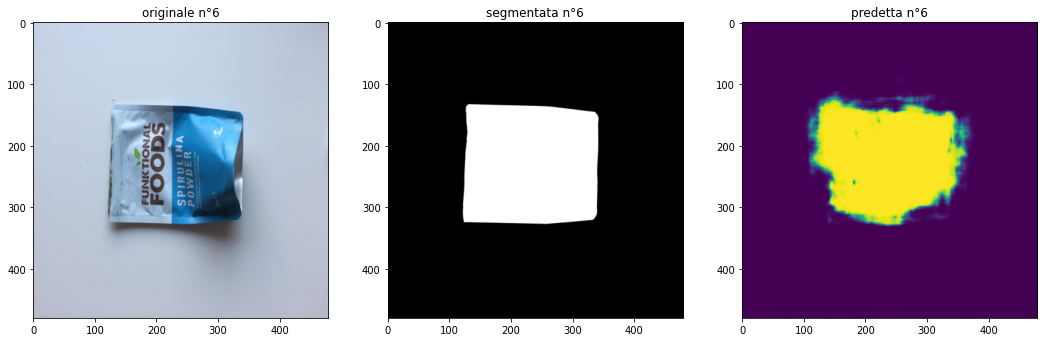

immagine n°: 6
IoU:  0.8142501338423221
F-Measure:  0.8976161761309692




In [65]:
predizione_metrica_singola(ID_img_pred,batch_img_pred, data_path)

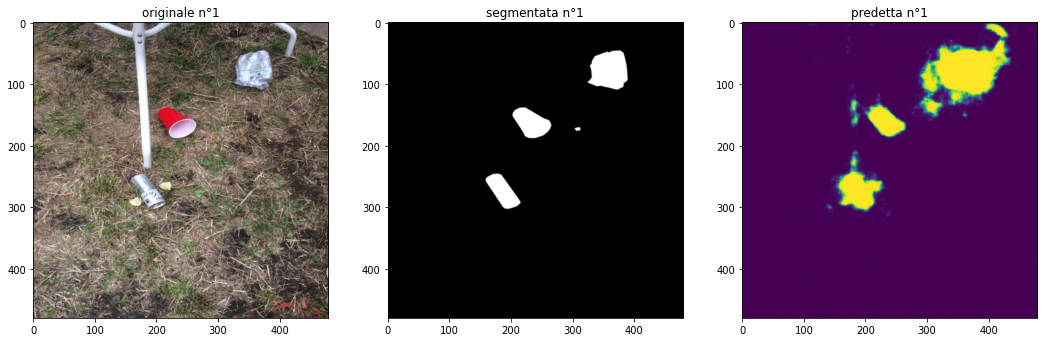

immagine n°: 1
IoU:  0.43298360655737705
F-Measure:  0.6043106209673729




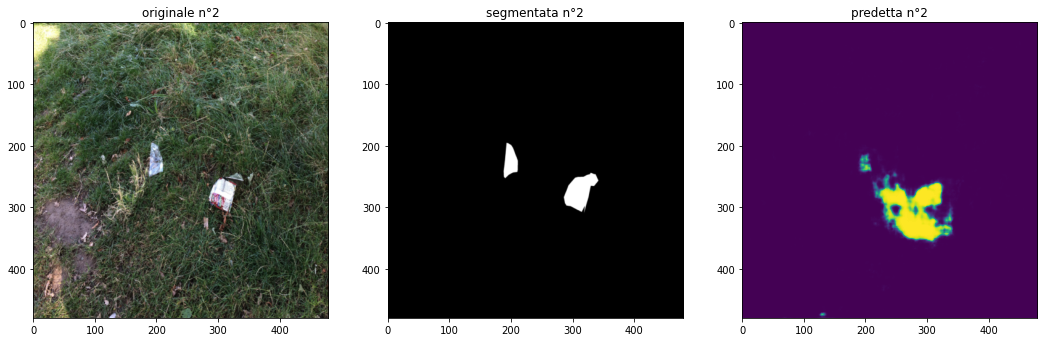

immagine n°: 2
IoU:  0.17421560249053838
F-Measure:  0.29673528800166354




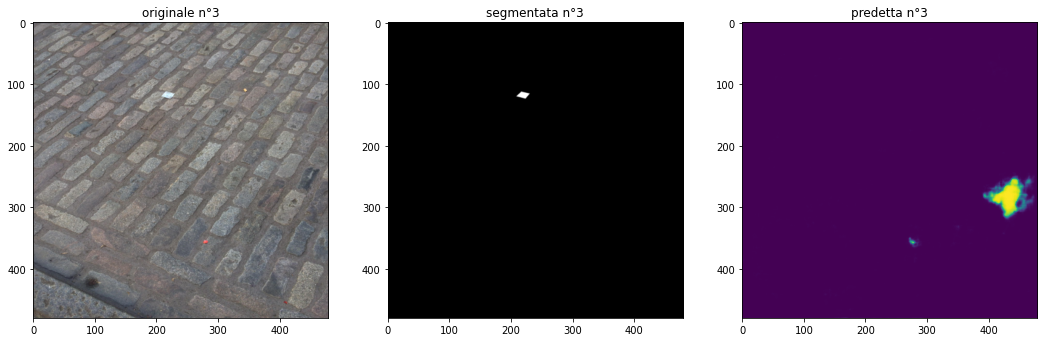

immagine n°: 3
IoU:  0.0
F-Measure:  0.0




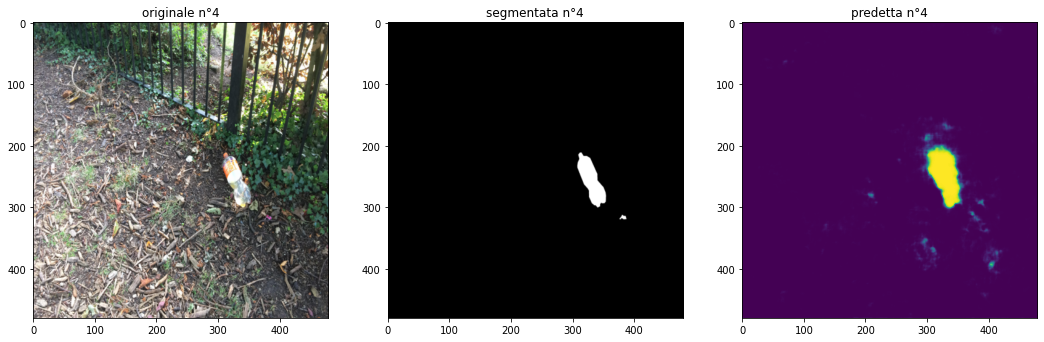

immagine n°: 4
IoU:  0.5530695770804911
F-Measure:  0.7122276879831342




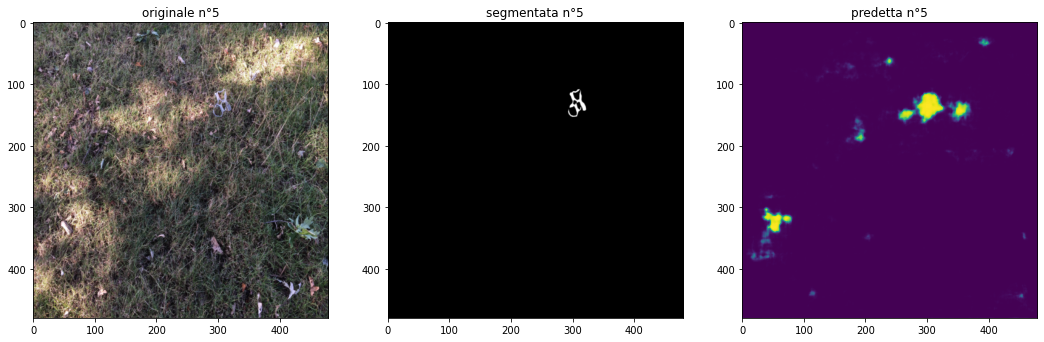

immagine n°: 5
IoU:  0.12849352419904567
F-Measure:  0.22772576260948355




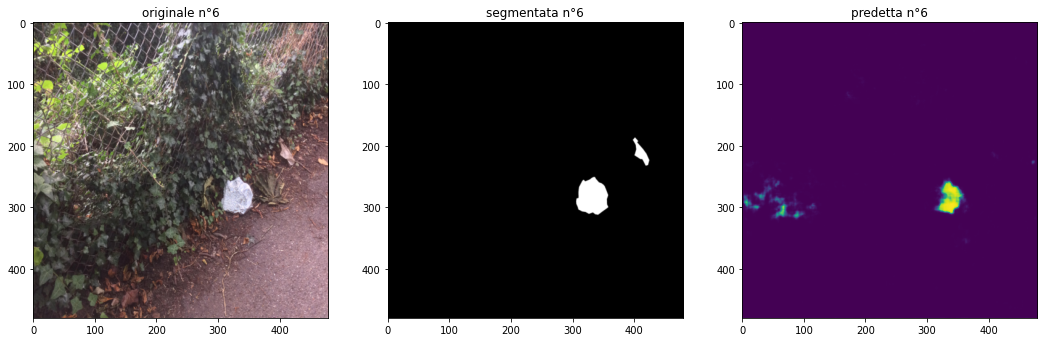

immagine n°: 6
IoU:  0.4114114114114114
F-Measure:  0.5829787234042553




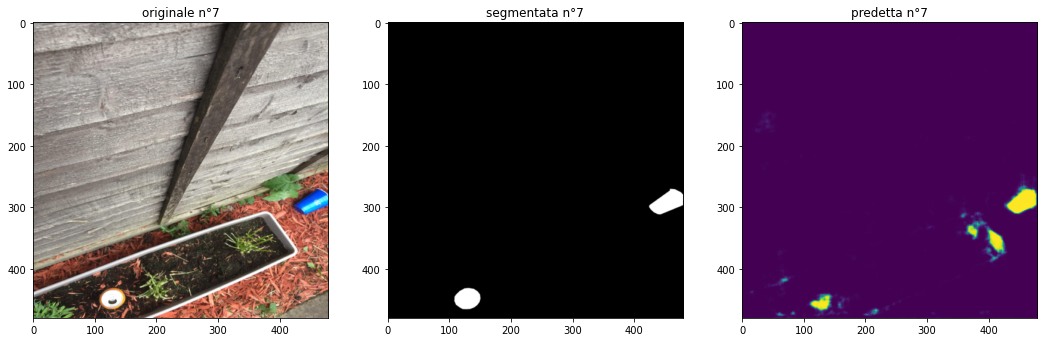

immagine n°: 7
IoU:  0.4934584755403868
F-Measure:  0.6608265092363359




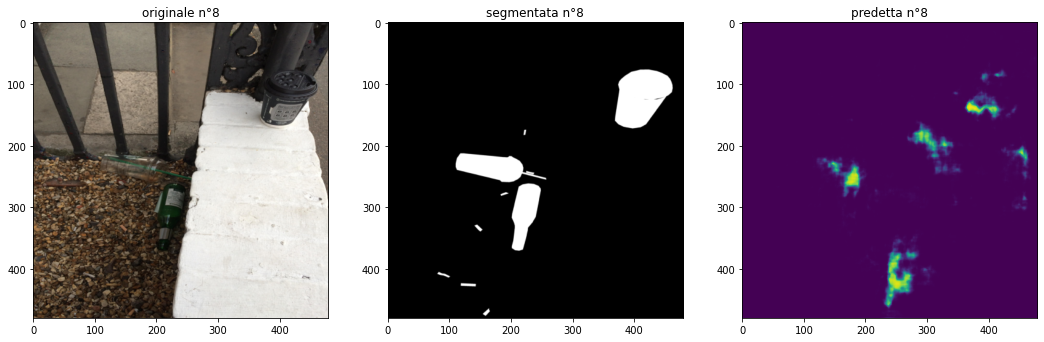

immagine n°: 8
IoU:  0.05214648026722751
F-Measure:  0.09912399318008114




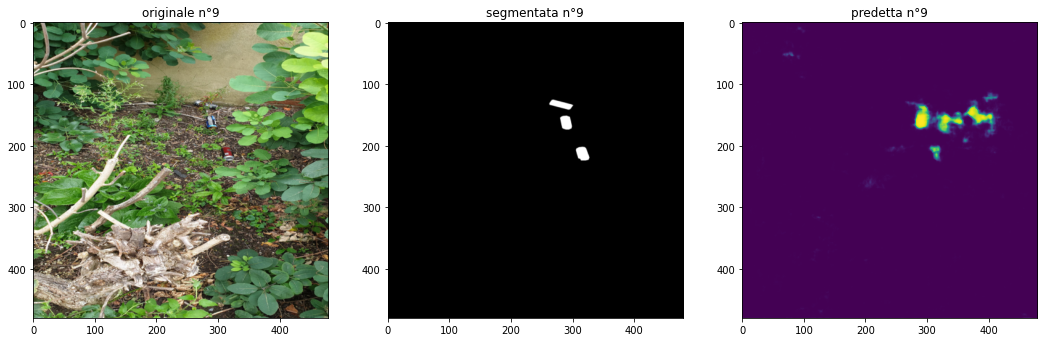

immagine n°: 9
IoU:  0.19155470249520154
F-Measure:  0.32152061855670105




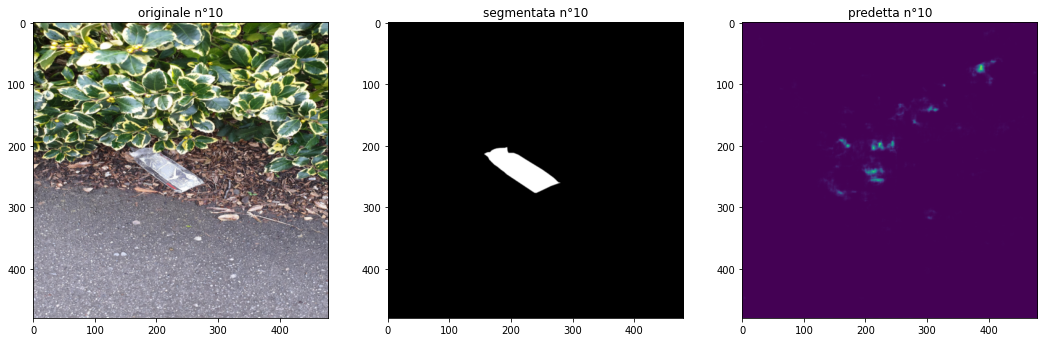

immagine n°: 10
IoU:  0.01235813366960908
F-Measure:  0.024414549078226207




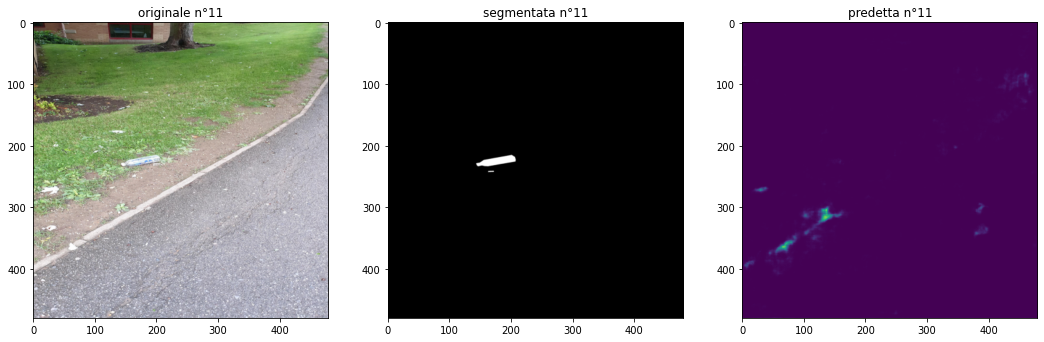

immagine n°: 11
IoU:  0.0
F-Measure:  0.0




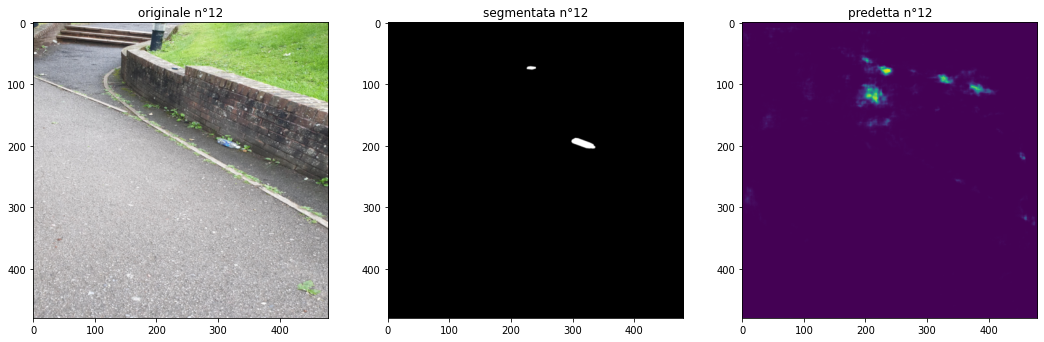

immagine n°: 12
IoU:  0.03304178814382896
F-Measure:  0.06396989651928504




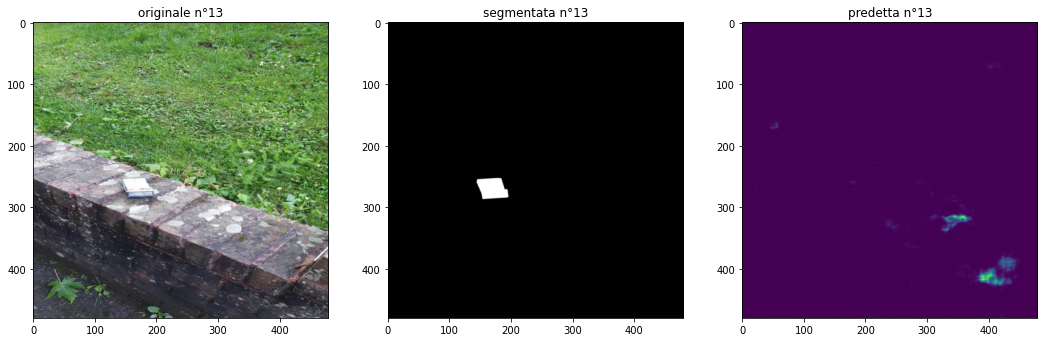

immagine n°: 13
IoU:  0.0
F-Measure:  0.0




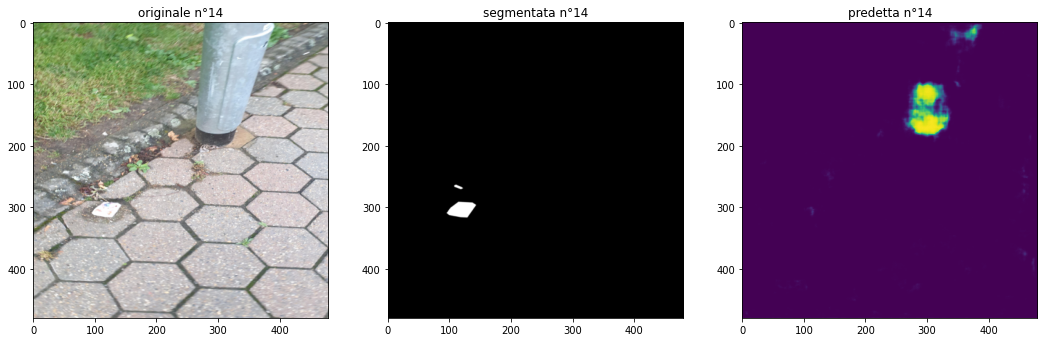

immagine n°: 14
IoU:  0.0
F-Measure:  0.0




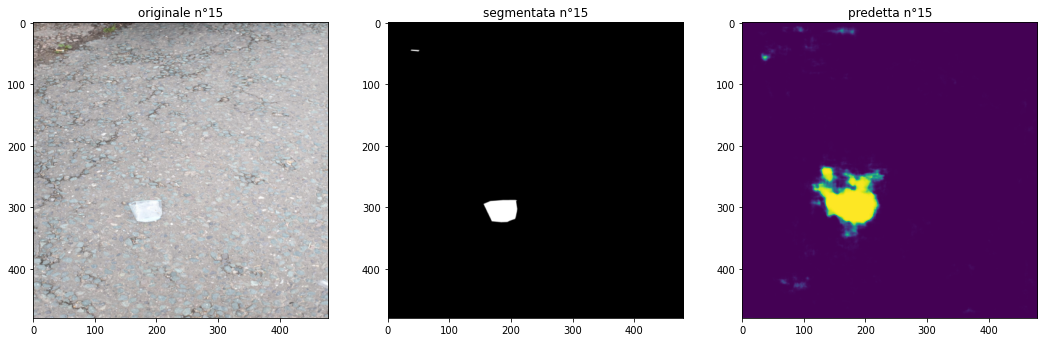

immagine n°: 15
IoU:  0.27714436063848447
F-Measure:  0.43400631781348714




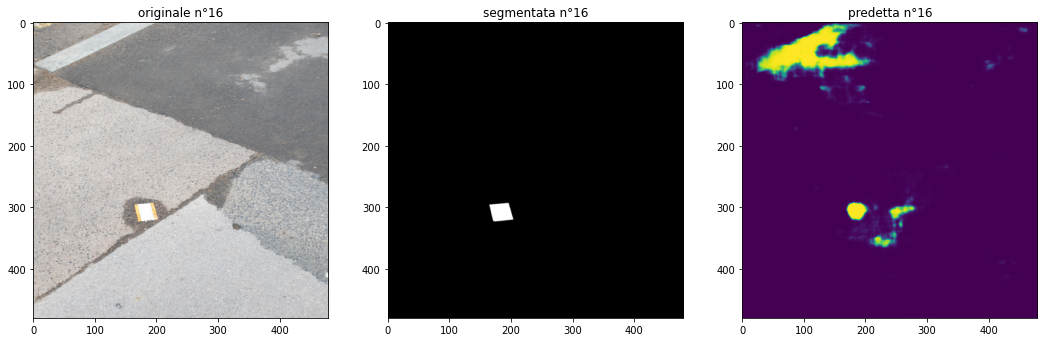

immagine n°: 16
IoU:  0.07656362329259525
F-Measure:  0.14223706176961604




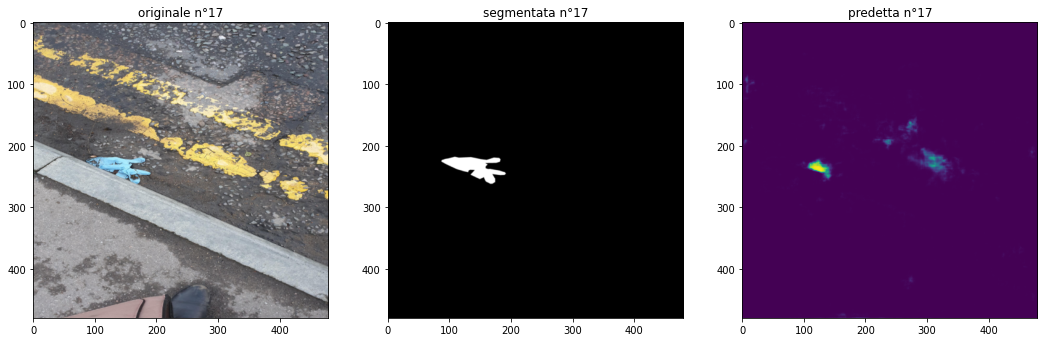

immagine n°: 17
IoU:  0.15715579710144928
F-Measure:  0.2716242661448141




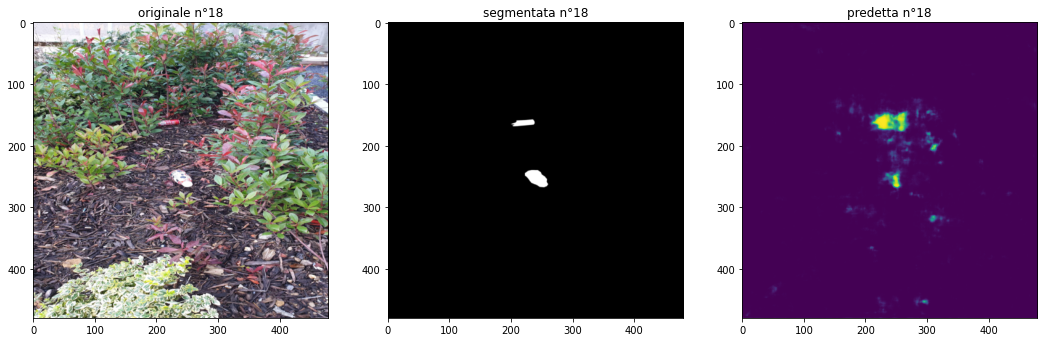

immagine n°: 18
IoU:  0.20048192771084336
F-Measure:  0.3340024086712164




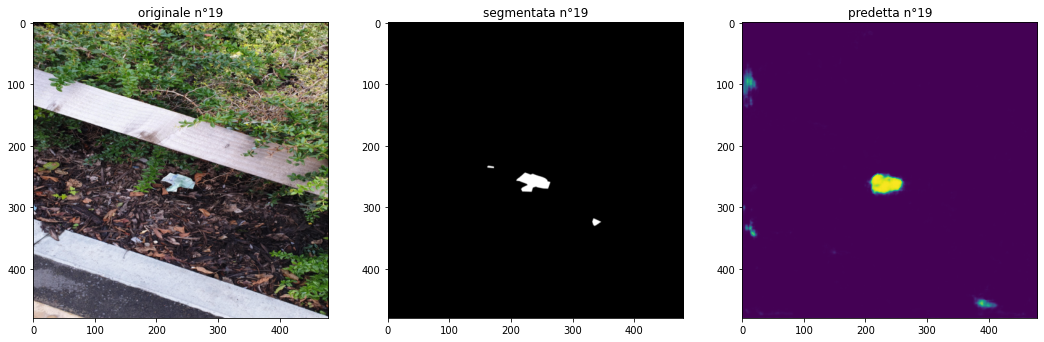

immagine n°: 19
IoU:  0.5289940828402366
F-Measure:  0.6919504643962848




In [66]:
predizione_metrica_batch(batch_pred, data_path)

In [67]:
# Osserva i dati
iou, fm, img = metriche_per_epoca(ID_img_camp, batch_img_camp, weights_path, epochs_num, data_path)

print("IoU:    \t    F-Measure:")
for i in range(len(iou)):
  print("\n", "{:.5f}".format(iou[i]), "\t\t", "{:.5f}".format(fm[i])) 

IoU:    	    F-Measure:

 0.00236 		 0.00472

 0.00000 		 0.00000

 0.00000 		 0.00000

 0.00159 		 0.00317

 0.00000 		 0.00000

 0.00015 		 0.00030

 0.00000 		 0.00000

 0.00000 		 0.00000

 0.01187 		 0.02347

 0.01319 		 0.02604

 0.01149 		 0.02273

 0.01954 		 0.03832

 0.04634 		 0.08857

 0.08729 		 0.16057

 0.30486 		 0.46727

 0.00000 		 0.00000

 0.28925 		 0.44870

 0.34499 		 0.51300

 0.53122 		 0.69385

 0.67222 		 0.80398

 0.77262 		 0.87172

 0.80506 		 0.89201

 0.82398 		 0.90350

 0.81639 		 0.89892

 0.82454 		 0.90383

 0.81699 		 0.89928

 0.81425 		 0.89762

 0.81599 		 0.89867

 0.81790 		 0.89983

 0.81652 		 0.89899

 0.81685 		 0.89920

 0.81668 		 0.89909

 0.81493 		 0.89803

 0.81524 		 0.89822

 0.81379 		 0.89734

 0.81410 		 0.89753

 0.81438 		 0.89770

 0.81237 		 0.89647

 0.81880 		 0.90037

 0.80882 		 0.89431

 0.82071 		 0.90153

 0.80789 		 0.89374

 0.81858 		 0.90024

 0.81318 		 0.89696

 0.81744 		 0.89955


In [68]:
loss_mean, iou_mean = net_data(mean_x_test, mean_y_test, epochs_num, weights_path)

2/2 [==============================] - 105s 53s/step - loss: 0.2954 - iou_score: 0.4319


In [ ]:
evaluate(x_final_batch, y_final_batch)

VALUTAZIONE SUI DATI DI TEST: 
3/3 [==============================] - 23s 2s/step - loss: 0.1694 - iou_score: 0.3541


## GRAFICI

In [69]:
fm_mean = []
test_b = (1,3,9,12,15)

for b in test_b:
    for id in range(0, 20):  
        fm_mean.append(metrica_singola(id,b,'fm', data_path))

array_on_file("/content/drive/MyDrive/Garbage_Detection/Data_Split/fm_mean.npy", fm_mean)

<Figure size 720x360 with 0 Axes>

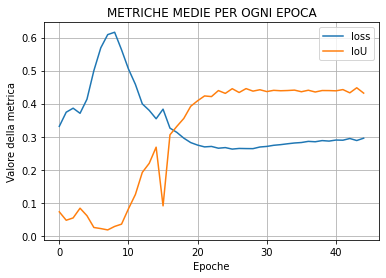

In [70]:
fig = plt.figure(figsize=(10,5))

# Subplots restituisce una tupla con figura ed asse
fig, ax = plt.subplots()

# Etichetta asse x
plt.xlabel('Epoche')
# Etichetta asse y
plt.ylabel('Valore della metrica')
# Titolo del plot
plt.title('METRICHE MEDIE PER OGNI EPOCA') 

# Plot line
ax.plot(loss_mean, label = 'loss')
ax.plot(iou_mean, label = 'IoU')

# Legenda del plot
plt.legend()
plt.grid()

fig.savefig(data_graph + 'metriche.png', bbox_inches='tight',  dpi=100)

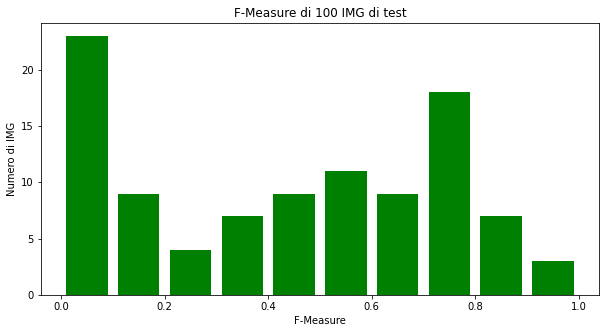

In [71]:
fig = plt.figure(figsize=(10,5))

# Set del range di osservazione e del numero di intervalli
value = (0, 1)      # Media aritmetica
bins = 10

# Plot di un istogramma
plt.hist(fm_mean, bins, value, color = 'green', histtype = 'bar', rwidth = 0.8)

# Etichetta asse x
plt.xlabel('F-Measure')
# Etichetta asse y
plt.ylabel('Numero di IMG')
# Titolo del plot
plt.title('F-Measure di 100 IMG di test')

fig.savefig(data_graph + 'fm.png', bbox_inches='tight', dpi=100)

# Funzione per mostrare il plot
plt.show()

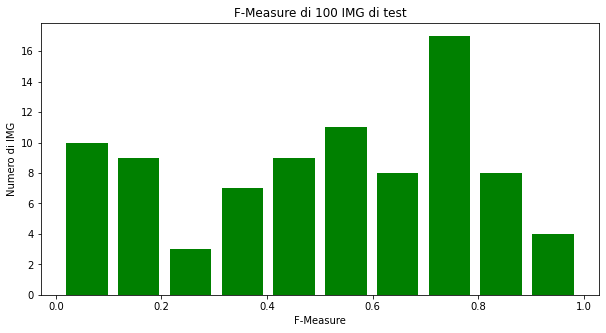

In [74]:
fig = plt.figure(figsize=(10,5))

# Set del range di osservazione e del numero di intervalli
value = (0.01,0.99)     # Media troncata eliminando valori estremi
bins = 10

# Plot di un istogramma
plt.hist(fm_mean, bins, value, color = 'green', histtype = 'bar', rwidth = 0.8)

# Etichetta asse x
plt.xlabel('F-Measure')
# Etichetta asse y
plt.ylabel('Numero di IMG')
# Titolo del plot
plt.title('F-Measure di 100 IMG di test')

fig.savefig(data_graph + 'fm-troncato.png', bbox_inches='tight', dpi=100)

# Funzione per mostrare il plot
plt.show()

# **ULTERIORI TEST**

**# SEGMENTAZIONE**

In [ ]:
for i in range(0, 15):                                                           # Scorre i batch
    num = str(i+1)  # numero del batch
    curr_dataset = batch_path + num                                             # Path batch corrente

    for fname in listdir(curr_dataset):                                         # Scorre ogni immagine del bacth
      if fname != 'segmentation':                                               # Controlla che non prenda la cartella segmentation e la converta a PNG

          curr_path = curr_dataset + '/segmentation/' + fname 		              # Path della cartella segmentation
          curr_path = curr_path[:curr_path.rfind(".")] + '.jpg'                 # Cambio formato in PNG

          fname = 'batch_' + num + '/' + fname                                  # Path immagine da analizzare
          
          # SEGMENTAZIONE
          print(fname)                                                          # Stampa immagine corrente

          id_img, dim_img = get_id_from_filename(fname)
          
          anns_sel = get_rle_form_image_id(id_img)

          #save_binary_img(curr_path, anns_sel, dim_img)
          dim_matrix = (dim_img[1], dim_img[0])
          old_mask = np.zeros( dim_matrix , dtype=float)                         # Creo una maschera vuota delle dimensioni dell'immagine dove caricare le maschere degli oggetti

          # Prende un oggetto alla volta 
          for ann in anns_sel:

              width = dim_img[0]
              height = dim_img[1]
              rles = cocomask.frPyObjects(ann['segmentation'], height, width)
              rle = cocomask.merge(rles)

              img_segmentata = cocomask.decode(rle) 

              if(len(anns_sel)>1):
                img_segmentata = np.logical_or(old_mask,img_segmentata)   # OR elemento per elemento: https://www.geeksforgeeks.org/numpy-array-logical-operations/?ref=rp
                old_mask = img_segmentata                                 # Così sovrappongo la prossima mask

          plt.imsave(curr_path, img_segmentata, cmap='gray')


%whos

**# STRETCH 480x480 (divisione batch 1-10 e 11-15)**

In [ ]:
initial_batch1 = 0
final_batch1 = 10
dimension = 480

npa_stretched1 = f_stretched(initial_batch1, final_batch1, dataset_path, dimension, 0)        # Chiamata alla funzione per stretchare la prima parte delle immagini del dataset
print(npa_stretched1.shape)

In [ ]:
initial_batch2 = 10
final_batch2 = 15
dimension = 480

npa_stretched2 = f_stretched(initial_batch2, final_batch2, dataset_path, dimension, 0)        # Chiamata alla funzione per stretchare la seconda parte delle immagini del dataset
print(npa_stretched2.shape)

In [ ]:
npa_stretched = np.concatenate((npa_stretched1, npa_stretched2))                              # Concateno le due parti di immagini stretchate
print(npa_stretched.shape)

# Salvo il vettore su un file .npy
array_on_file("npa_stretched.npy", npa_stretched)                                             # È Possibile mettere anche un path del drive ed evitare il download

In [ ]:
from google.colab import files
files.download('npa_stretched.npy') 

In [ ]:
initial_batch1 = 0
final_batch1 = 10
dimension = 480

npa_segm_stretched1 = f_stretched(initial_batch1, final_batch1, dataset_path, dimension, 1)        # Chiamata alla funzione per stretchare la prima parte delle immagini del dataset
print(npa_segm_stretched1.shape)

In [ ]:
initial_batch2 = 10
final_batch2 = 15
dimension = 480

npa_segm_stretched2 = f_stretched(initial_batch2, final_batch2, dataset_path, dimension, 1)        # Chiamata alla funzione per stretchare la seconda parte delle immagini del dataset
print(npa_segm_stretched2.shape)

In [ ]:
npa_segm_stretched = np.concatenate((npa_segm_stretched1, npa_segm_stretched2))                    # Concateno le due parti di immagini stretchate
print(npa_segm_stretched.shape)

# Salvo il vettore su un file .npy
array_on_file("npa_segm_stretched.npy", npa_segm_stretched)                                         # È Possibile mettere anche un path del drive ed evitare il download

In [ ]:
from google.colab import files
files.download('npa_segm_stretched.npy') 

**UNZIP**: successivamente al download dei file npy abbiamo zippato i file tramite 7zip e caricati sul drive così da ridurre l'occupazione di memoria nel drive, successivamente per utilizzarli li unzippavamo tramite comandi. 

N.B. Utilizzare parte del link del file sul drive per il download.
  Esempio:  
   drive.google.com/file/d/ **1qzQ60g6yoL1yPg5-6Jum2V6vtEjebXJU** /view?usp=sharing 

In [ ]:
!gdown --id 1cj8h3m7FOLGs4dMAMg515LXSK-gK2-mC                                   # Link del drive da aggiornare      
!7z e npa_stretched_512.7z
npa_stretched = array_from_file("npa_stretched.npy")
print(npa_stretched.shape)

In [ ]:
!gdown --id 1qzQ60g6yoL1yPg5-6Jum2V6vtEjebXJU                                   # Link del drive da aggiornare
!7z e npa_stretched_512.7z
npa_stretched = array_from_file("npa_segm_stretched.npy")
print(npa_stretched.shape)